# GROUP PROJECT PROPOSAL
Group 22 - Jeffery Hu, Ben Lu, Gurjas Singh Chawla, Feiran Hu

## Introduction:

K-nearest neighbour is the process in which data is classified based on its similarity with its neighbours, allowing us to predict the class of a new observation based on a known training data set. This proposal will demonstrate a preliminary data analysis, state how we will be using K-nearest neighbour classification, and what we are expecting to discover.

Statistically speaking in sports, left-handed players perform better - whether that be because their opponents are unfamiliar with playing against a lefty or they are simply more coordinated. We thought it would be interesting to see if there would be any correlation between a tennis player’s handedness and their other attributes, or more formally:

Is there a relationship between the handedness of a tennis player with their peak rank, current rank, height, age, and their backhand grip - i.e. can we derive the former by looking at their other attributes?

To answer our questions we will be using the Player Stats for Top 500 Players.

## Preliminary Exploratory Data Analysis:


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.plot.width = 12)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Reading Data

In [2]:
# tennis player data acquried from https://www.ultimatetennisstatistics.com/
url = "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
download.file(url, "player_data.csv")

# player data with only the columns we want
player_data <- read_csv("player_data.csv")|> select(Age, Plays, `Current Rank`, `Best Rank`, Backhand, Height)
colnames(player_data) <- c("age", "handedness", "curr_rank", "best_rank", "backhand_grip", "height") 

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Wrangling, Tidying, and Cleaning Data

In [3]:
# player data formatted - char fields converted to numerical and categorical fields converted to factors
#                       - removes the necessary parts of each variable like the birthdays after each players' age,
#                         which is a cell that contains more than one value hence untidy
player_data_formatted <- player_data |>
    mutate(age = as.numeric(sapply(strsplit(age," "), getElement, 1)), 
           curr_rank = as.numeric(sapply(strsplit(curr_rank," "), getElement, 1)), 
           best_rank = as.numeric(sapply(strsplit(best_rank," "), getElement, 1)),
           height = as.numeric(sapply(strsplit(height," "), getElement, 1)),
           backhand_grip = as_factor(backhand_grip),
           handedness = as_factor(handedness)
          )

# splitting data into training and testing sets
players_split <- initial_split(player_data_formatted, prop = 3/4, strata = handedness)
players_train <- training(players_split)
players_test <- testing(players_split)

players_train

age,handedness,curr_rank,best_rank,backhand_grip,height
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
18,Left-handed,326,316,Two-handed,NA
23,Left-handed,431,319,Two-handed,NA
24,NA,375,283,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮
28,Right-handed,292,74,Two-handed,NA
32,Right-handed,416,137,Two-handed,NA
26,Right-handed,5,4,One-handed,185


### Summarize

In [4]:
# this summarization table allows us to see the distribution of handedness among players
handedness_distribution <- players_train |>
    filter(!is.na(handedness)) |>
    group_by(handedness) |>
    summarize(count = n())

# this summarization table allows us to see how many variables we are missing for each of the predictors 
# as well as the handedness of the players, this gives us an idea of which variable we should put 
# more emphasis on (rank & age) and which to potentially discard (height)
missing_variables <- players_train |>
    summarize(across(everything(), ~ sum(is.na(.))))

handedness_distribution
missing_variables

handedness,count
<fct>,<int>
Right-handed,293
Left-handed,46


age,handedness,curr_rank,best_rank,backhand_grip,height
<int>,<int>,<int>,<int>,<int>,<int>
1,35,2,1,64,289


### Visualization

`summarise()` has grouped output by 'handedness'. You can override using the
`.groups` argument.


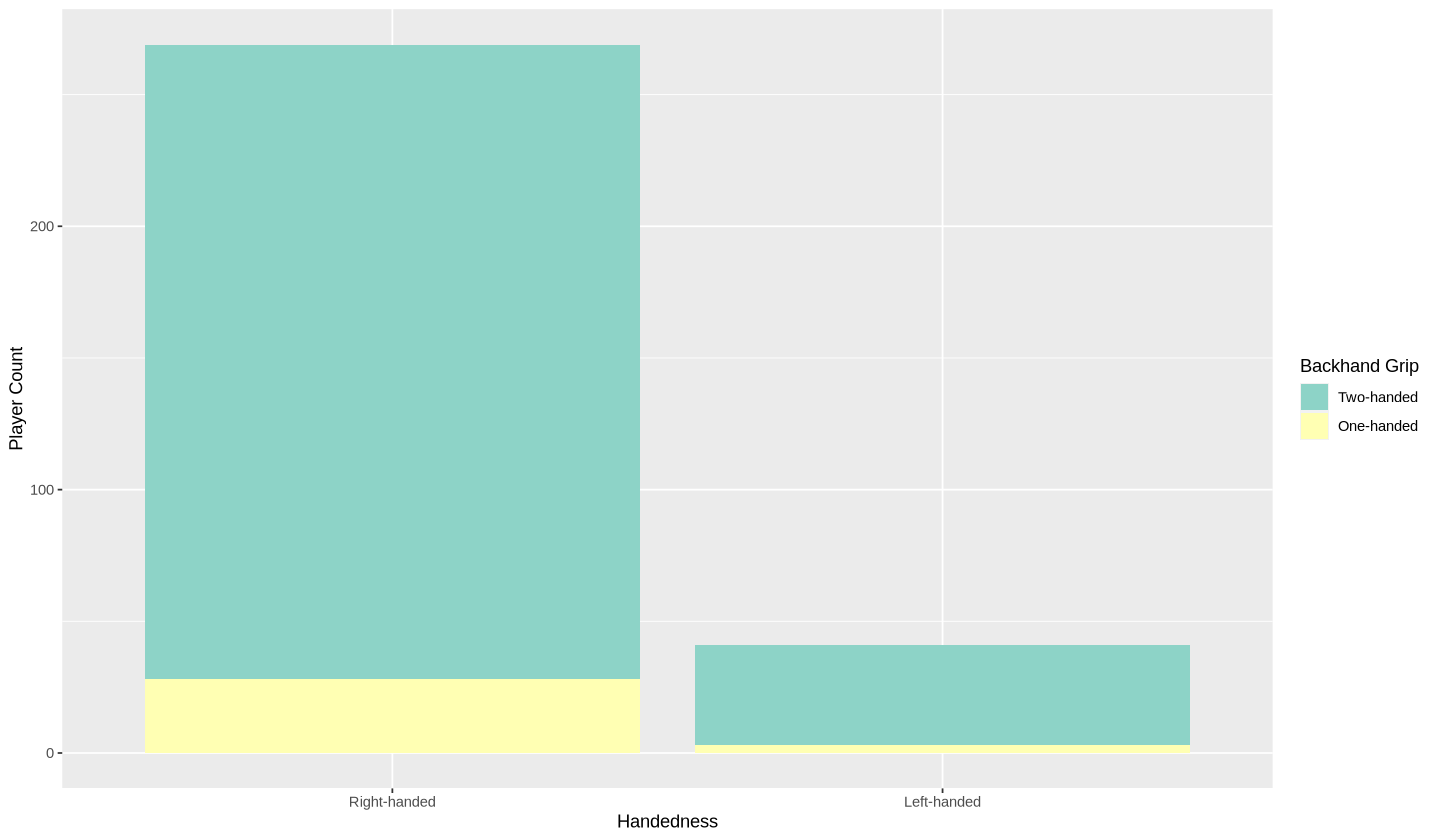

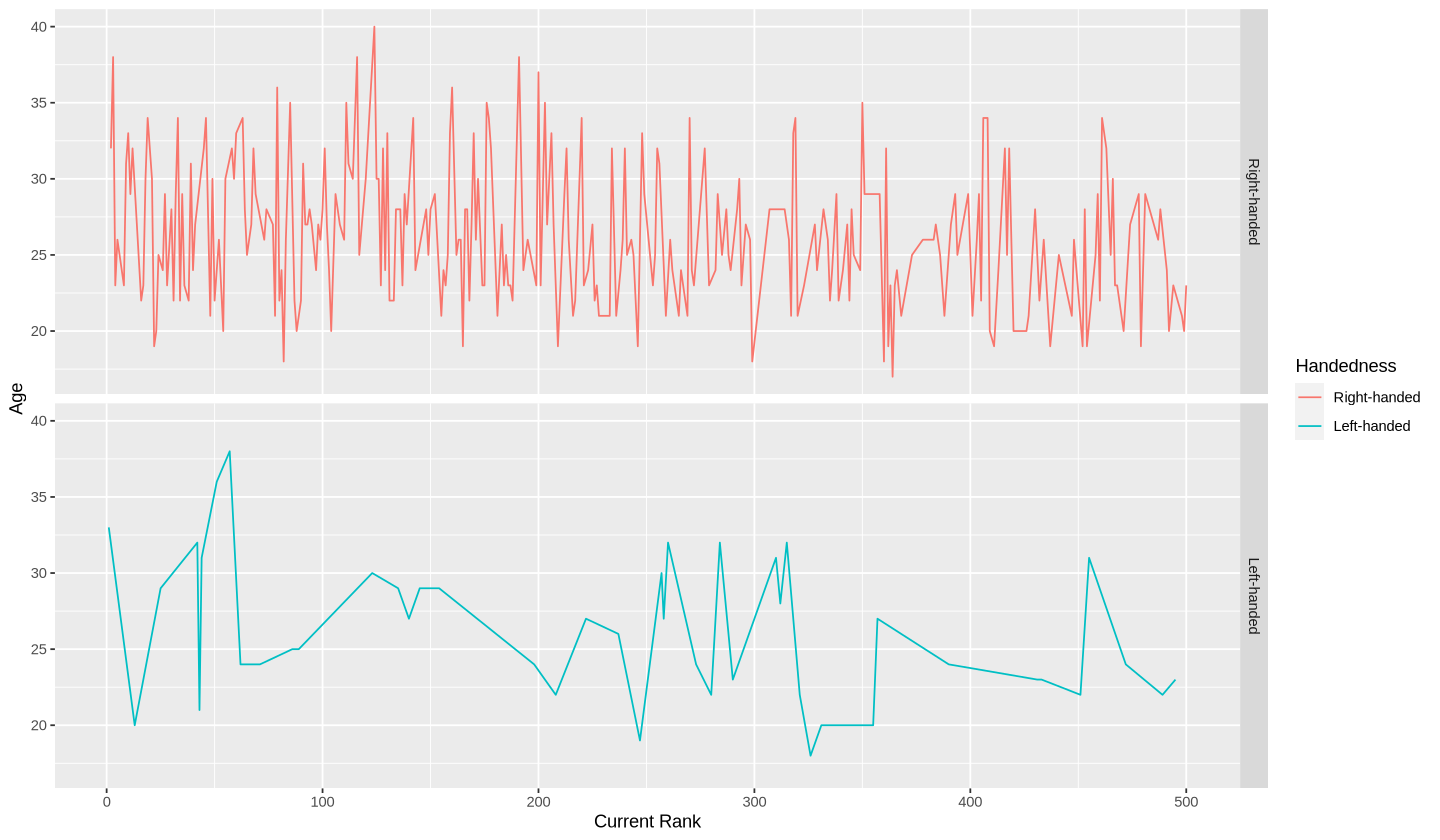

In [6]:
# visualizes the distribution of the handedness of players vs what their backhand grip is
handedness_backhand_distribution <- players_train |>
    filter(!is.na(handedness), !is.na(backhand_grip)) |>
    group_by(handedness, backhand_grip) |>
    summarize(count = n())

ggplot(handedness_backhand_distribution, aes(x = handedness, y = count, fill = backhand_grip)) + 
    geom_bar(stat = 'identity') +
    labs(x="Handedness", y = "Player Count", fill = "Backhand Grip") +
    scale_fill_brewer(palette = 'Set3')

# visualizes the distribution of age v.s. current rank of a player in respect to handedness
players_age_rank_handedness <- players_train |>
    filter(!is.na(handedness), !is.na(curr_rank), !is.na(age)) |>
    select(handedness, curr_rank, age)

ggplot(players_age_rank_handedness, aes(x = curr_rank, y = age, color = handedness)) +
    geom_line() +
    labs(x="Current Rank", y = "Age", color = "Handedness") +
    facet_grid(rows = vars(handedness))

## Methods
Predictors (these variables are either physical attributes or factors that can impact / be impacted by the handedness of a player):
- Current rank
- Peak rank
- Height
- Age
- Backhand grip

Variables omitted (we believe none of these variables would have an effect / would be directly affected by the handedness of a player):
- Country
- Name
- Prize money
- Turned pro
- Season


Having multiple predictors, we have the opportunity to plot the handedness of a player against a multitude of their other attributes. An example could be the players' preference for backhand grip v.s. their dominant hand, which we have done for this proposal's preliminary data analysis.


## Expected Outcome & Significance
The two main conclusions we can draw are either 1.) physical attributes and performance metrics of players have a real correlation with their handedness and 2.) the opposite where there are no real correlations. Though we believe outcome 2 is more likely based on our preliminary data analysis, seeing a certain combination of handedness, grip style, and other physical attributes would be interesting.

Such findings could have an impact in the coaching of the sport. Understanding how handedness and other physical attributes contribute to the performance of a player can allow coaches to tailor and build their programs more effectively as they would take into account the natural advantages of left-handed players or develop strategies to counteract these advantages in the competitive scene of tennis.

A future question could be if our findings are consistent when observing other racquet sports like badminton, squash, and table tennis. Doing so might reveal whether the observed trends in tennis are universal or sport-specific and offer a broader perspective on the role of handedness in sports. Furthermore, longitudinal studies like tracking the evolution of athletes' performance metrics over time could show us how handedness impacts career development and longevity, providing a more nuanced understanding of the long-term effects of handedness on sports careers of players.
